In [2]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sharingBikeDatamining').getOrCreate()

# cenmancen.aka.ajg!
* fjfjfj

In [52]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [54]:
dailyData = pd.read_csv('/home/ubuntu/sharing-bike-data-mining/hour.csv')

In [57]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weathersit.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

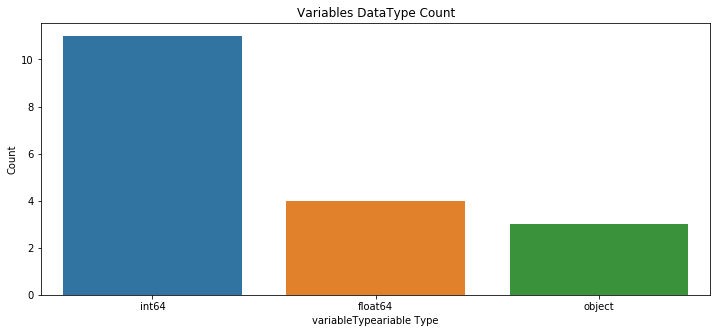

In [58]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

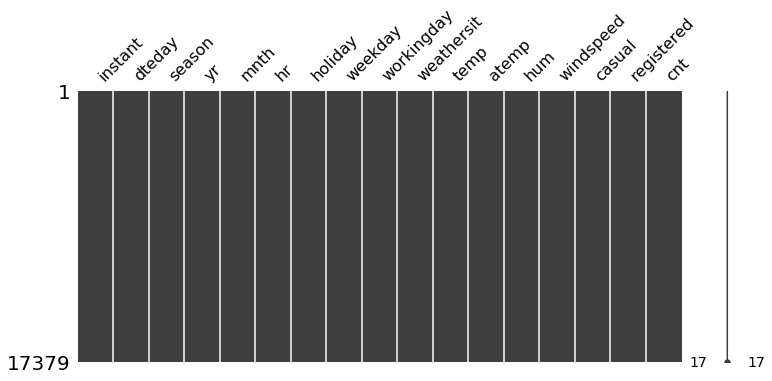

In [35]:
msno.matrix(dailyData,figsize=(12,5))

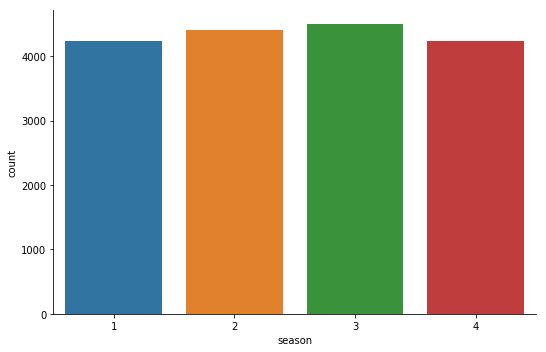

In [40]:
sn.catplot(x='season',data=dailyData,kind='count',height=5,aspect=1.5)

In [59]:
dailyData.dtypes

instant         int64
dteday         object
season         object
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
weather        object
dtype: object

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

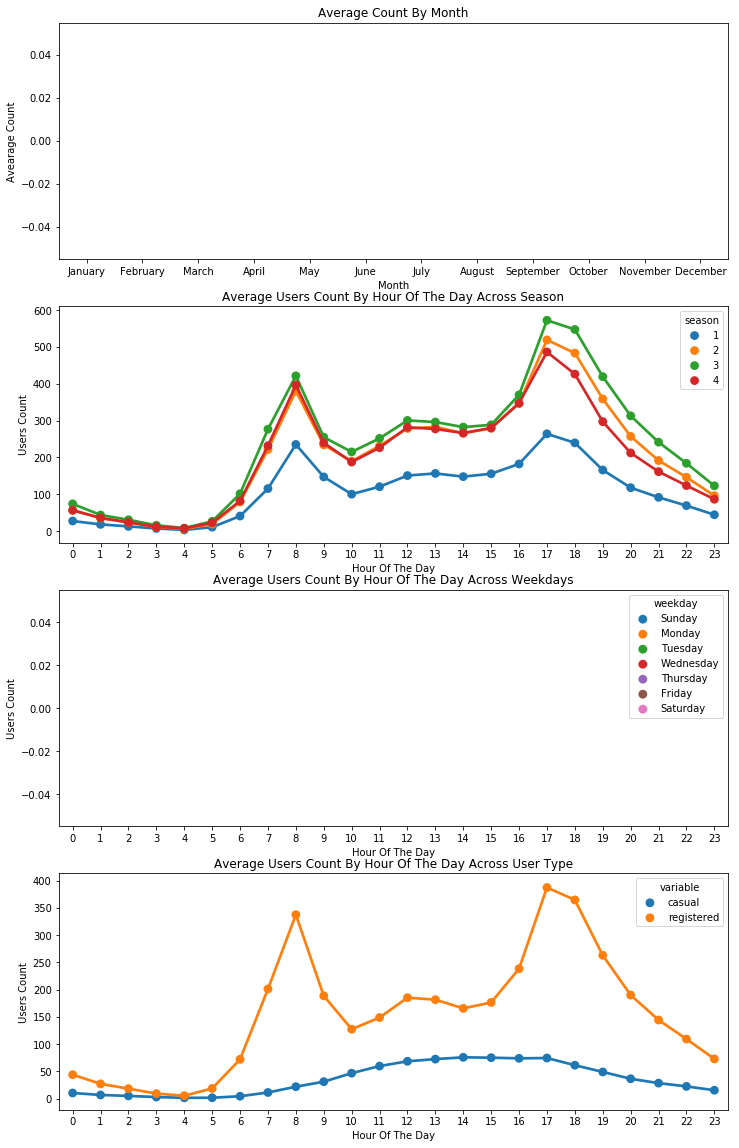

In [50]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="mnth",y="cnt",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')
